# Feature Selection Methods

This notebook is dedicated to performing feature selection using the best model found during autoML. The following approaches are considered:
   - SelectKBest: will use ANOVA to keep only the most relevant features
   - SequentialForwardSelection: will greedily build an estimator from an empty subset of features
    
The first method is a filtering method, meaning that it does not consider interactions between variables. while fast, this family of methods does not guarantee the generation of the most performing feature subset. Sequential Forward Floating Selection on the other hand is a wrapper method, that will consider interaction between the features, but it is very slow when the number of features is significant.

In [1]:
#For development
#Reload the library when a change is detected in one of the imported libraries
%load_ext autoreload 
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

In [3]:
from src import feature_selection as fs

# Setting up

Load the gold dataframe (the one read to be ingested by the machine learning algorithms, where missing values are removed).

In [4]:
df = pd.read_csv('Data/Train_gold.csv')
df.head()

,Ang,ReL,ReG,FrL,FrG,NL,X_LM,X_LM_2,Y,We,Eo,HU,K_G,T_TB,Flow_label
0,70.0,24466.450000,4732.370333,1.977684,0.167038,0.067433,9.536429,90.943470,9396.899099,342.061243,87.456055,0.855173,26.127659,0.009094,2
1,15.0,41756.000000,771.757367,3.375242,0.027241,0.108119,27.565536,759.858750,8411.876527,996.322021,87.456055,0.855671,5.566427,0.023380,2
2,-1.0,40000.000000,31.466667,3.233300,0.001111,0.104080,131.415812,17270.115534,-13911.758220,914.285714,87.456055,0.869445,0.222135,0.021665,1
3,0.0,1967.834702,9344.647280,1.237211,0.121114,0.111560,23.916428,571.995542,0.000000,267.242284,174.589416,0.705758,5.372648,0.024891,2
4,0.0,3847.587937,438975.247408,0.394137,1.052936,0.017198,0.648012,0.419920,0.000000,235.178898,1513.924625,0.150659,65.312469,0.000592,0


In [5]:
target = 'Flow_label'
features = df.columns.drop(target)

Split features from labels

In [6]:
X, y = df[features], df[target].values.ravel()

# Univariate Feature Selection
The next statistical test is actually to select the best K perfomring features. This is done using the ANOVA test for the variables in the dataframe. Note that using this type of filter does not guarantee generating a list of the best meaningfull variables, since the interactions are not taken into account. Nonetheless is a good test to perform. For the time being we select 80% of the features, of course this is a choice dicated by a random number I had in mind when creating this notebook.

In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif

In [8]:
feat_to_keep = round(0.8*len(X.columns))
univariate_model = SelectKBest(score_func=f_classif, k=feat_to_keep)
univariate_model.fit(X, y)

SelectKBest(k=11)

## Plot the ANOVA Feature Importance
Once we have determined the best performing features, the next step is to actually plot their importance

In [9]:
X.columns = [r'$\theta$', r'$Re_{L}$', r'$Re_{G}$', 
             r'$Fr_{L}$', r'$Fr_{G}$', r'$N_{L}$', 
             r'$X_{LM}$', r'$X_{LM}^2$', r'$Y$', 
             r'$We$', r'$Eo$', r'$\alpha_{L}$', 
             r'$K_{G}$', r'$T_{TB}$']

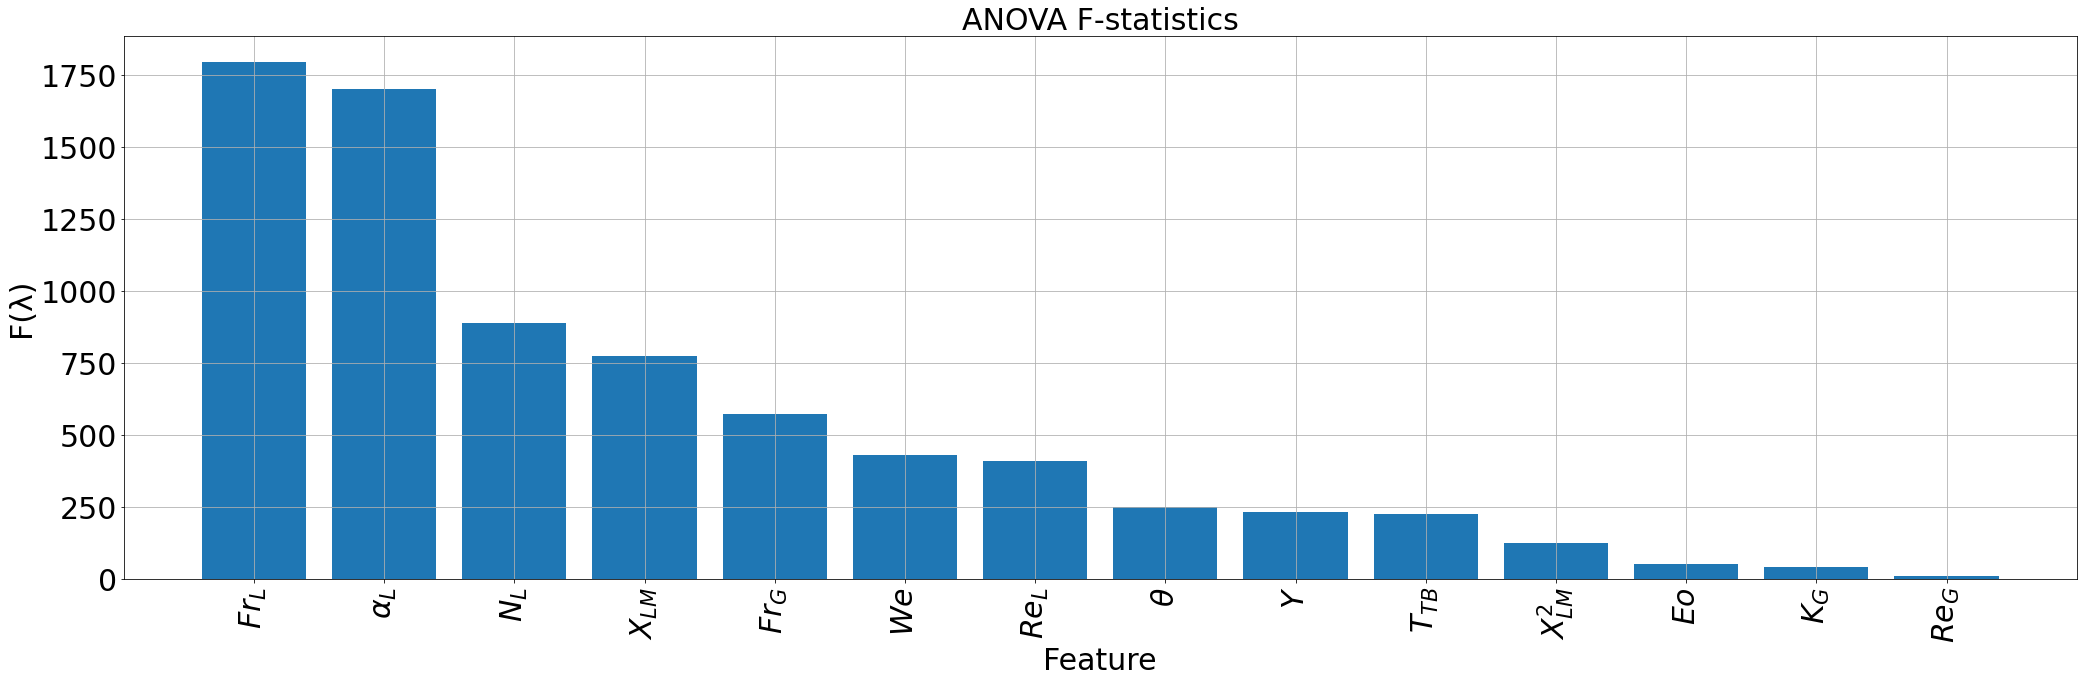

In [10]:
model = f_classif(X, y)
ANOVA_data = {'Features': X.columns, 'F_score': model[0]}
imp_f_classif = pd.DataFrame(ANOVA_data).sort_values(by='F_score', ascending=False)
fs.plot_ANOVA(imp_f_classif)

## Step Forward Feature Selection
Here we perfrom the step forward feature selection. This technique will use a greedy strategy to build the best performing model. Note that every feature kept will never be discarded in future steps unless the floating method is set to true.

In [11]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from imblearn.over_sampling import SMOTE

import lightgbm as lgbm

In [12]:
estimator = lgbm.LGBMClassifier()
sfs=SFS(estimator, k_features=6, forward=True, 
        floating=True, scoring='balanced_accuracy', 
        verbose=0, cv=5, n_jobs=-1)

In [13]:
sfs.fit(X, y)

SequentialFeatureSelector(estimator=LGBMClassifier(), floating=True,
                          k_features=6, n_jobs=-1, scoring='balanced_accuracy')

In [14]:
info_di = sfs.get_metric_dict()
l = [list(info_di[x]['feature_names']) for x in info_di.keys()]
scores = fs.generate_SFFSinfo(X, y, l, balance_method=SMOTE())

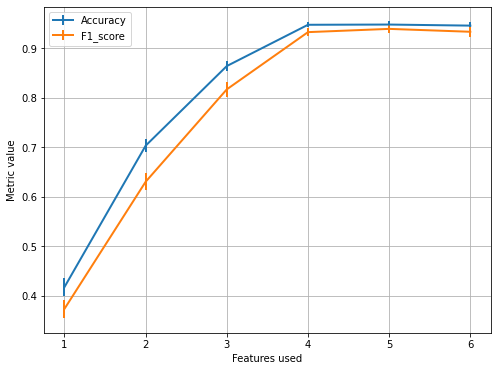

In [15]:
fs.plot_SFFS(scores)